In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.fftpack import fft,ifft
from schrodinger import Schrodinger
import matplotlib.pyplot as plt
import scipy
import sympy as sp

from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='jshtml')
import seaborn as sns

#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('poster', font_scale=0.9,  rc={"lines.linewidth": 5})

In [3]:
# specify constants
hbar = 1.0   # planck's constant
m = 1.9      # particle mass

In [4]:
#define x grid:
x = np.linspace(-30,30,3000)

# specify potential at grid points
V_x = np.zeros(shape=x.shape)

In [5]:
#Specify initial wave function at grid points:
@np.vectorize
def psiF(x,sigma=1.0,mu=0.0,k0=1):
    norm = 1/(np.pi*sigma**2)**(1/4)
    f = np.exp(-(x-mu)**2/(4*sigma**2))
    f *= np.exp(np.complex(0,k0*x))
    
    return  norm*f
    
psi_x0 = psiF(x=x)

In [6]:
# define the Schrodinger object which performs the calculations
S = Schrodinger(x=x,  psi_x0=psi_x0, V_x=V_x,
                    hbar=hbar, m=m)

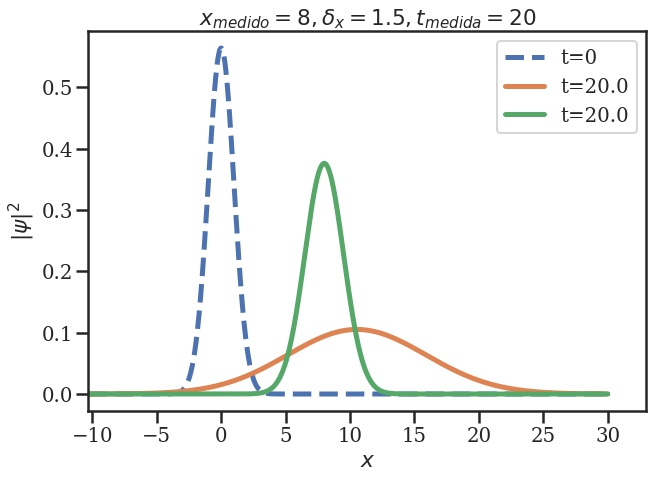

In [7]:
fig = plt.figure(figsize=(10,7))
plt.plot(x,np.abs(S.psi_x)**2,linestyle='--',label=r't=0')
S.time_step(dt=1e-2,Nsteps=2000)
plt.plot(S.x,np.abs(S.psi_x)**2,label=r't=%1.1f'%S.t)

#Colapso:
x0 = 8 #Measurement in x= 8
delta_x = 1.5 #measurement precision
psi_x0 = psiF(x=x,sigma=delta_x,mu=x0)
Snew = Schrodinger(x=x,  psi_x0=psi_x0, V_x=V_x,
                    hbar=hbar, m=m)
plt.plot(x,np.abs(Snew.psi_x)**2,label=r't=%1.1f' %S.t)
plt.legend(loc='upper right')
plt.xlabel(r'$x$')
plt.ylabel(r'$|\psi|^2$')
plt.xlim(-10.30)
plt.title(r'$x_{medido} = %1.0f, \delta_x = %1.1f, t_{medida} = %1.0f$' %(x0,delta_x,S.t))
plt.savefig('wavePacketColapso.png')
plt.show()

### Animation:

In [8]:
######################################################################
# define the Schrodinger object which performs the calculations
psi_x0 = psiF(x=x)
S = Schrodinger(x=x,  psi_x0=psi_x0, V_x=V_x,
                    hbar=hbar, m=m)
S.measured = False
tm = 15.0

# Set up plot
fig,ax1 = plt.subplots(nrows=1,ncols=1,figsize=(10,8))

psi_x_line, = ax1.plot([], [])
psi_x_line_freeze, = ax1.plot([], [],alpha=0.4,c=psi_x_line.get_color())
ax1.set_xlabel('$x$')
ax1.set_ylabel(r'$|\psi(x)|^2$')
title = ax1.set_title("")
ax1.set_xlim(x.min(),x.max())
ax1.set_ylim(0,max(np.abs(psi_x0)**2))


# Animate plot
def init():
    psi_x_line.set_data([], [])
    psi_x_line_freeze.set_data([], [])
    title.set_text("")
    return (psi_x_line, psi_x_line_freeze, title)

def animate(i):
    S.time_step(dt, N_steps)
    #Colapso em t = tm:
    if not S.measured and np.abs(S.t-tm) <= N_steps*dt:
        psi_x_line_freeze.set_data(S.x, np.abs(S.psi_x)**2)
        S.measured = True
        psi_x0 = psiF(x=x,sigma=delta_x,mu=x0)#Re-iniciar função de onda
        S.psi_x = psi_x0    
        psi_x_line.set_color('g')
    psi_x_line.set_data(S.x, np.abs(S.psi_x)**2)

    if S.measured:
        title.set_text("t = %.2f (apos a medida)" % S.t)
    else:
        title.set_text("t = %.2f" % S.t)
        
    return (psi_x_line, psi_x_line_freeze, title)

# call the animator.  blit=True means only re-draw the parts that have changed.
dt = 0.005
N_steps = 50
t_max = 30
frames = int(t_max / float(N_steps * dt))

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, interval=100, blit=True)

#Para salvar corretamente, tem que descomentar a linha de baixo
anim.save('schrodingerColapso.mp4', fps=15, extra_args=['-vcodec', 'libx264'])

#Para ver o video no notebook deve comentar a linha de cima
plt.close()
anim
